In [1]:
!pip install numpy pandas matplotlib seaborn spacy gensim wordcloud
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 55.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


#Importing

In [2]:
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 600)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
import spacy
import random
from gensim import models, corpora, similarities
from wordcloud import WordCloud
import os
from google.colab import drive

#Connecting Drive

In [4]:
drive.mount('/content/drive')

drive_path = '/content/drive/My Drive/Colab Notebooks'

os.chdir(drive_path)

!pwd

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


#Loading Data

In [5]:
songs_df = pd.read_csv("Spotify App Reviews.csv")

print(songs_df.columns)

songs_df = pd.read_csv("Spotify App Reviews.csv")
data = list(songs_df["Review"])

print("Number of songs:", len(data))
print("\nFirst song:", data[0])

Index(['Time_submitted', 'Review', 'Rating', 'Total_thumbsup', 'Reply'], dtype='object')
Number of songs: 61594

First song: Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.


In [6]:
clean_data = [i.replace('\n','').replace('\r','') for i in data]

#Tokenizer

In [7]:
nlp = spacy.load("en_core_web_sm")

unwanted_pipes = ["ner", "parser"]

def custom_tokenizer(doc):
    with nlp.disable_pipes(*unwanted_pipes):
        return [t.lemma_ for t in nlp(doc) if t.is_alpha and not t.is_space and not t.is_punct and not t.is_stop and t.pos_ in ["ADJ","NOUN","VERB"]]

In [8]:
%%time

tokenized_data = list(map(custom_tokenizer, nlp.pipe(clean_data, n_process=5)))


CPU times: user 7min 41s, sys: 1.99 s, total: 7min 43s
Wall time: 9min 23s


#Modelling

In [9]:
dct = corpora.Dictionary(tokenized_data)

print('Size of vocabulary before filtering:', len(dct))

dct.filter_extremes(no_below=5, no_above=0.5)

print('\nSize of vocabulary after filtering:', len(dct))

print("\nExample mappings:", [(i,dct.token2id[i]) for i in tokenized_data[0][:10]])

print(tokenized_data[0])

Size of vocabulary before filtering: 14917

Size of vocabulary after filtering: 3667

Example mappings: [('great', 4), ('music', 6), ('service', 9), ('audio', 1), ('high', 5), ('quality', 7), ('app', 0), ('easy', 2), ('use', 11), ('quick', 8)]
['great', 'music', 'service', 'audio', 'high', 'quality', 'app', 'easy', 'use', 'quick', 'friendly', 'support']


In [10]:
bow = [dct.doc2bow(i) for i in tokenized_data]

In [11]:
print(dct.doc2bow(tokenized_data[0]))

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]


In [12]:
print(len(bow))
print(len(dct))

61594
3667


#Training model

In [13]:
%%time

lda_model = models.LdaModel(corpus=bow, num_topics=10, passes=10, alpha='auto', eta='auto', id2word=dct, random_state=0)

CPU times: user 1min 39s, sys: 1.59 s, total: 1min 41s
Wall time: 1min 40s


In [14]:
lda_model.print_topics()

[(0,
  '0.235*"ad" + 0.181*"premium" + 0.079*"free" + 0.043*"user" + 0.040*"version" + 0.037*"minute" + 0.025*"buy" + 0.018*"worth" + 0.015*"get" + 0.014*"listening"'),
 (1,
  '0.108*"artist" + 0.086*"lyric" + 0.056*"nice" + 0.050*"sound" + 0.031*"genre" + 0.025*"favourite" + 0.024*"perfect" + 0.021*"cool" + 0.021*"suggestion" + 0.019*"base"'),
 (2,
  '0.132*"feature" + 0.076*"remove" + 0.033*"min" + 0.028*"advertisement" + 0.028*"queue" + 0.027*"right" + 0.023*"scroll" + 0.023*"see" + 0.023*"slow" + 0.021*"pc"'),
 (3,
  '0.050*"work" + 0.045*"update" + 0.042*"time" + 0.041*"play" + 0.039*"fix" + 0.038*"app" + 0.037*"stop" + 0.032*"try" + 0.030*"phone" + 0.025*"problem"'),
 (4,
  '0.175*"song" + 0.072*"play" + 0.059*"listen" + 0.054*"playlist" + 0.041*"want" + 0.030*"like" + 0.029*"add" + 0.019*"skip" + 0.016*"new" + 0.015*"thing"'),
 (5,
  '0.178*"app" + 0.148*"music" + 0.098*"spotify" + 0.075*"good" + 0.055*"love" + 0.045*"great" + 0.039*"use" + 0.023*"find" + 0.018*"listen" + 0.015*

In [15]:
print(lda_model.alpha)
print(lda_model.eta)

[0.6314759  0.3814337  0.29509473 1.8119105  2.4112527  2.41461
 0.3810423  0.36471635 0.34835333 0.922937  ]
[0.11136344 0.08331316 0.07465486 ... 0.06721532 0.06712127 0.06674561]


#Top topics in corpus

In [16]:
topics = list(lda_model.get_document_topics(bow, minimum_probability=0))

for i in range(10):
    print(f"Topic {i} proportion: {100*sum([pair[i][1] for pair in topics])/len(topics):.1f}%")

Topic 0 proportion: 6.2%
Topic 1 proportion: 3.6%
Topic 2 proportion: 2.7%
Topic 3 proportion: 19.1%
Topic 4 proportion: 24.6%
Topic 5 proportion: 24.6%
Topic 6 proportion: 3.6%
Topic 7 proportion: 3.4%
Topic 8 proportion: 3.3%
Topic 9 proportion: 8.9%


In [17]:
print(topics[0])
print(topics[0][0])
print(topics[0][0][1])

[(0, 0.07427392), (1, 0.017690225), (2, 0.05894884), (3, 0.08399304), (4, 0.1098143), (5, 0.42269954), (6, 0.06332562), (7, 0.016606886), (8, 0.015861817), (9, 0.13678584)]
(0, 0.07427392)
0.07427392


#Top topics in song

In [18]:
def get_top_topics(song_idx, min_prob):

    topics = sorted(lda_model.get_document_topics(bow[song_idx], minimum_probability=min_prob), key=lambda tup: tup[1])[::-1]

    pairs = [lda_model.show_topic(pair[0]) for pair in topics]
    topic_words = [[pair[0] for pair in topic] for topic in pairs]

    return pd.DataFrame({'Major Topics': topics,'Topic Words': topic_words})

In [19]:
display(get_top_topics(100, 0.25))
print(data[100][:300])

,Major Topics,Topic Words
0,"(3, 0.43303308)","[work, update, time, play, fix, app, stop, try, phone, problem]"
1,"(5, 0.2606578)","[app, music, spotify, good, love, great, use, find, listen, need]"


I love listening to music (I use it as a coping mechanism), so I love Spotify so much too. But, about 3 days ago (?), my Spotify wouldn't load, it would just stay on the spotify logo screen thing. Tried installing it and uninstalling it for 5 times, restarted my phone 2 times, cleared the cache/data


In [20]:
topics = sorted(lda_model.get_document_topics(bow[100], minimum_probability=0.25), key=lambda tup: tup[1])[::-1]

pairs = [lda_model.show_topic(pair[0]) for pair in topics]
topic_words = [[pair[0] for pair in topic] for topic in pairs]

print(topics[0])
print(topics[0][0])
print(pairs[0])
print(topic_words)

(3, 0.43303284)
3
[('work', 0.050079904), ('update', 0.04544412), ('time', 0.041820135), ('play', 0.040515196), ('fix', 0.039387178), ('app', 0.038187232), ('stop', 0.036701243), ('try', 0.031638123), ('phone', 0.029753262), ('problem', 0.025219953)]
[['work', 'update', 'time', 'play', 'fix', 'app', 'stop', 'try', 'phone', 'problem'], ['app', 'music', 'spotify', 'good', 'love', 'great', 'use', 'find', 'listen', 'need']]


#Evaluating Topics

In [21]:
coherence_model = models.coherencemodel.CoherenceModel(model=lda_model, texts=tokenized_data, dictionary=dct, coherence='u_mass')
coherence_score = coherence_model.get_coherence()
print(f'Coherence Score: {coherence_score:.4f}')

Coherence Score: -4.8427


#Visualizing Topics

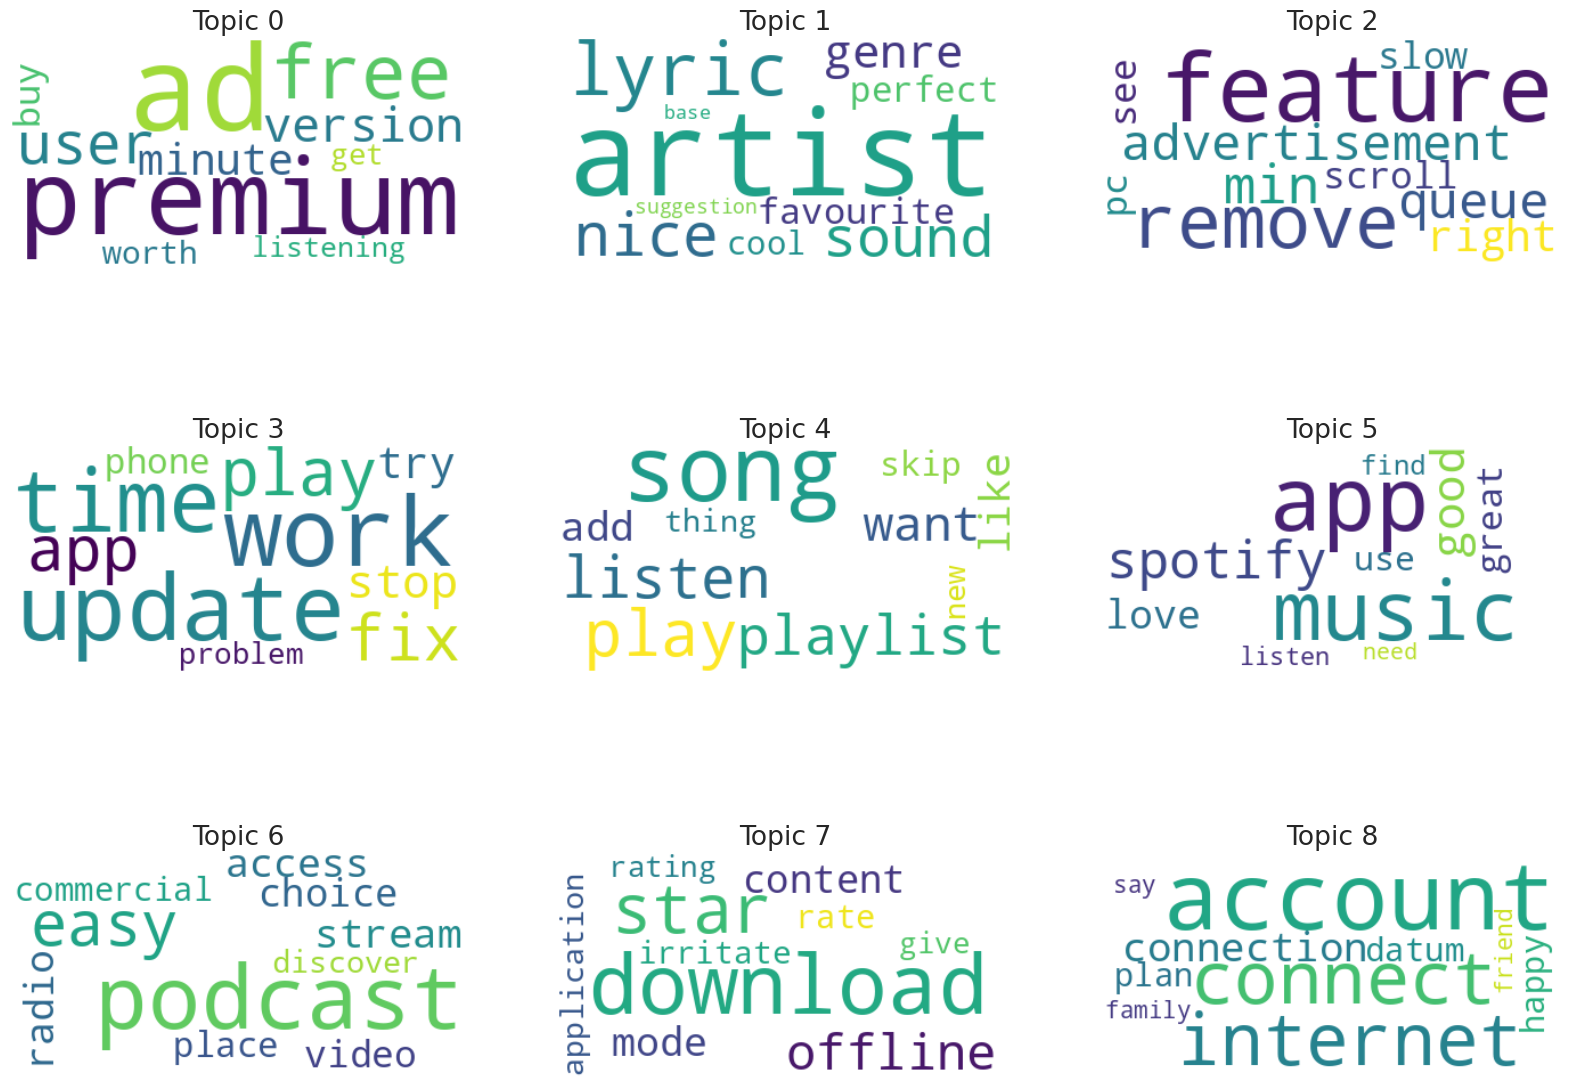

In [22]:
word_cloud = WordCloud(background_color='white', max_words=10)
fig, axes = plt.subplots(3, 3, figsize=(20,15))

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(lda_model.show_topic(i))
    word_cloud.generate_from_frequencies(topic_words)
    plt.gca().imshow(word_cloud, interpolation='bilinear')
    plt.gca().set_title(f'Topic {i}')
    plt.gca().axis('off')
plt.show()

#Finding Similar Documents

In [23]:
lda_index = similarities.MatrixSimilarity(lda_model[bow], num_features=len(dct))

In [24]:
def get_similar_songs(song_bow, top_n=5, first_m_words=300):
    similar_songs = lda_index[lda_model[song_bow]]
    top_n_docs = sorted(enumerate(similar_songs), key=lambda item: -item[1])[1:top_n+1]

    return list(map(lambda entry: (entry[0], entry[1], clean_data[entry[0]][:first_m_words]), top_n_docs))

In [25]:
print(data[6864][:300],'\n')
get_similar_songs(bow[6864])

I say it honestly a amazing app, because I love the fact that you can create your own playlist. 



[(48715,
  0.99999917,
  'This app is best to listen song but there are some songs that are not in Spotify'),
 (37819,
  0.9999986,
  "It's Awesome.....we can listen to any song I recommend this app to anyone who loves music....😙😙😙😙😙"),
 (15454,
  0.99999857,
  'Amazing app if you love to listen to songs highly recommend'),
 (20073,
  0.99999857,
  "Absolutely amazing, i really love this app. I get to listen to any of my songs without being on YouTube to do it. I highly recommend it for anyone who hasn't used it"),
 (9053,
  0.9999985,
  'Its best app for music I used to listen old song of india')]

In [26]:
new_song = "Demons on my shoulder Monsters in my head Shadow in the water Will you be my friend The world revolves around me As I lay in my bed Dreaming of more, more"
new_tokens = list(map(custom_tokenizer, [nlp(new_song)]))[0]
new_bow = dct.doc2bow(new_tokens)

print(new_song,'\n')
get_similar_songs(new_bow)

Demons on my shoulder Monsters in my head Shadow in the water Will you be my friend The world revolves around me As I lay in my bed Dreaming of more, more 



[(52537,
  0.98551524,
  "I can't find lyrics since long now !! I took premium plans !!! ,. Still I can't see lyrics ,,, and my friends with free version are getting lyrics 🥲. , Do something Spotify 🙏 My device: OnePlus 6"),
 (54371,
  0.9800545,
  'Everything is fine except the pricing, I would be better to give some offers for customers to buy premium'),
 (11298,
  0.9787826,
  'hope also for poor with minus datavoliums a enter for free music thanks maybe the time come when pure come rich than me pay a 1 euro ok so than now only thank you for get a bit free music less datavolium away free child che 11544'),
 (21654,
  0.9787617,
  'Spotify should\'ve a "music soulmate" in their yearly wrap up where they match is with the person that has the most similar music taste to you based on your listening habits.'),
 (15527,
  0.9778465,
  "Can't believe I'm writing this but Spotify has horrible sound quality compared to Anghami. I tried playing the same song here and there and the distortion 